#Objective & Dataset Introduction
This analysis aims to predict whether a traffic crash results in injury using a historical dataset from Chicago. The dataset includes various environmental, vehicular, and situational attributes (e.g., weather, lighting, control device) that may influence injury outcomes. The goal is to:


* Preprocess and clean the data

* Explore and visualize key relationships

* Engineer features and prepare them for modeling

* Train and evaluate classification and regression models

#Step 1: Load and Inspect the Dataset
We begin by loading the dataset, displaying the shape, the first few records, and a summary of data types and statistical information to understand the structure and content.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = 'Dataset for Data Mining.csv'  # replace with your actual path
df = pd.read_csv(file_path)

# Display basic info
print("🗃️ Shape:", df.shape)
print("\n📌 First 5 rows:")
print(df.head())

print("\n🧾 Dataset Info:")
print(df.info())

print("\n📊 Summary Statistics:")
print(df.describe(include='all').T)


🗃️ Shape: (235978, 48)

📌 First 5 rows:
                                     CRASH_RECORD_ID CRASH_DATE_EST_I  \
0  ec987eca9d84e964c10e750c95b8dca890036480463020...              NaN   
1  deafa5f8bdd844d7154eae177cbd86bf5754991a0c7e77...              NaN   
2  96577eb19233057b1bf0b40befc1acbcc26b21fe7abb93...              NaN   
3  31e890ddbd9c76afdcd32bcda5f8e885311cf486b8afae...              NaN   
4  49dcf06cc6debf56fea45cbdd5c07156bd0bc6a475657c...              NaN   

               CRASH_DATE  POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE  \
0  11/19/2019 09:20:00 AM                30.0            NO CONTROLS   
1  02/12/2025 01:00:00 PM                35.0         TRAFFIC SIGNAL   
2  12/30/2022 09:50:00 PM                30.0            NO CONTROLS   
3  07/15/2018 10:00:00 PM                25.0            NO CONTROLS   
4  10/27/2024 10:30:00 PM                30.0            NO CONTROLS   

       DEVICE_CONDITION WEATHER_CONDITION      LIGHTING_CONDITION  \
0           NO CONT

# Step 2: Handle Missing Data and Clean Dataset
Missing values can skew analysis and lead to model inaccuracies. We handle them using the following logic:

* Fill categorical columns with the most frequent value (mode)

* Fill numerical columns with the median, which is more robust to outliers

* Drop any duplicate records

* Remove records with invalid speed limits (e.g., 0 or over 100)

* Detect and remove outliers using the Interquartile Range (IQR) method

In [3]:
# Display percentage of missing values
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
print("\n🚨 Missing Values (%):\n", missing_percent[missing_percent > 0])

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numeric columns with median
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())



🚨 Missing Values (%):
 WORKERS_PRESENT_I                99.866513
DOORING_I                        99.690649
WORK_ZONE_TYPE                   99.574537
WORK_ZONE_I                      99.450796
PHOTOS_TAKEN_I                   98.606650
STATEMENTS_TAKEN_I               97.680716
NOT_RIGHT_OF_WAY_I               95.451695
CRASH_DATE_EST_I                 92.641687
LANE_CNT                         78.934477
INTERSECTION_RELATED_I           77.102527
HIT_AND_RUN_I                    68.662757
REPORT_TYPE                       3.243946
LONGITUDE                         0.770835
LATITUDE                          0.770835
LOCATION                          0.769987
MOST_SEVERE_INJURY                0.230106
INJURIES_NON_INCAPACITATING       0.228411
INJURIES_REPORTED_NOT_EVIDENT     0.227987
INJURIES_TOTAL                    0.227140
INJURIES_UNKNOWN                  0.225869
INJURIES_FATAL                    0.225445
INJURIES_INCAPACITATING           0.225021
INJURIES_NO_INDICATION        

In [4]:
# Drop duplicates
print("🧹 Duplicates Removed:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Handle invalid POSTED_SPEED_LIMIT values
df = df[df['POSTED_SPEED_LIMIT'] > 0]
df = df[df['POSTED_SPEED_LIMIT'] < 100]  # sensible upper limit

# Remove outliers in numerical features using IQR
for col in ['POSTED_SPEED_LIMIT', 'INJURIES_TOTAL', 'CRASH_HOUR']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


🧹 Duplicates Removed: 17


# Step 3: Visualize Important Features
To understand data distribution and detect any potential patterns, we visualize weather conditions and correlations among numerical features.

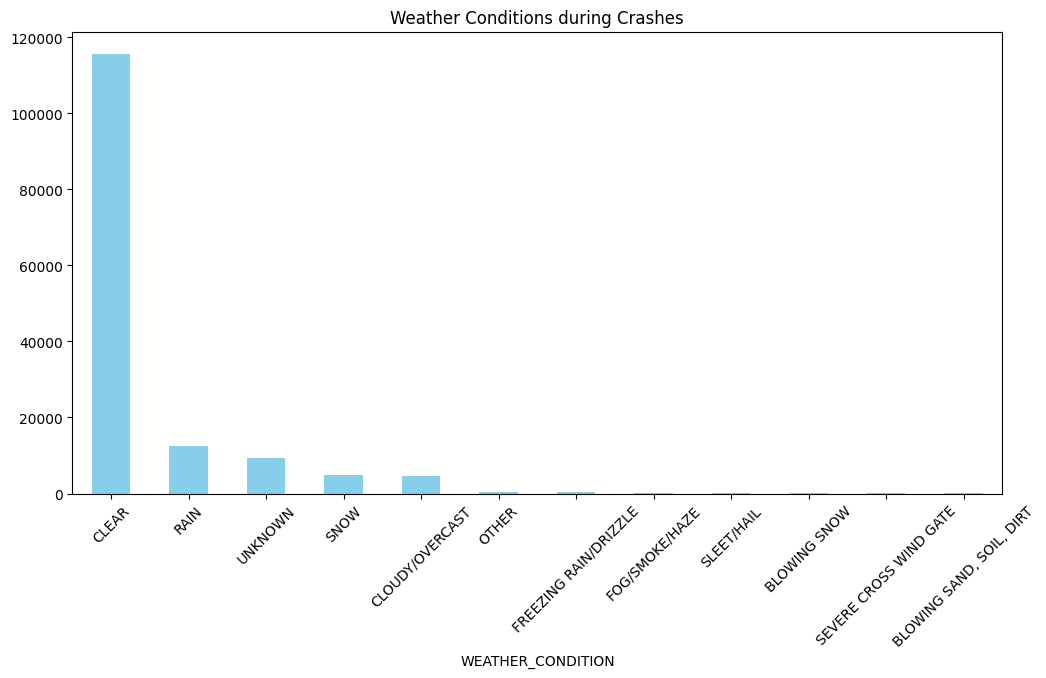

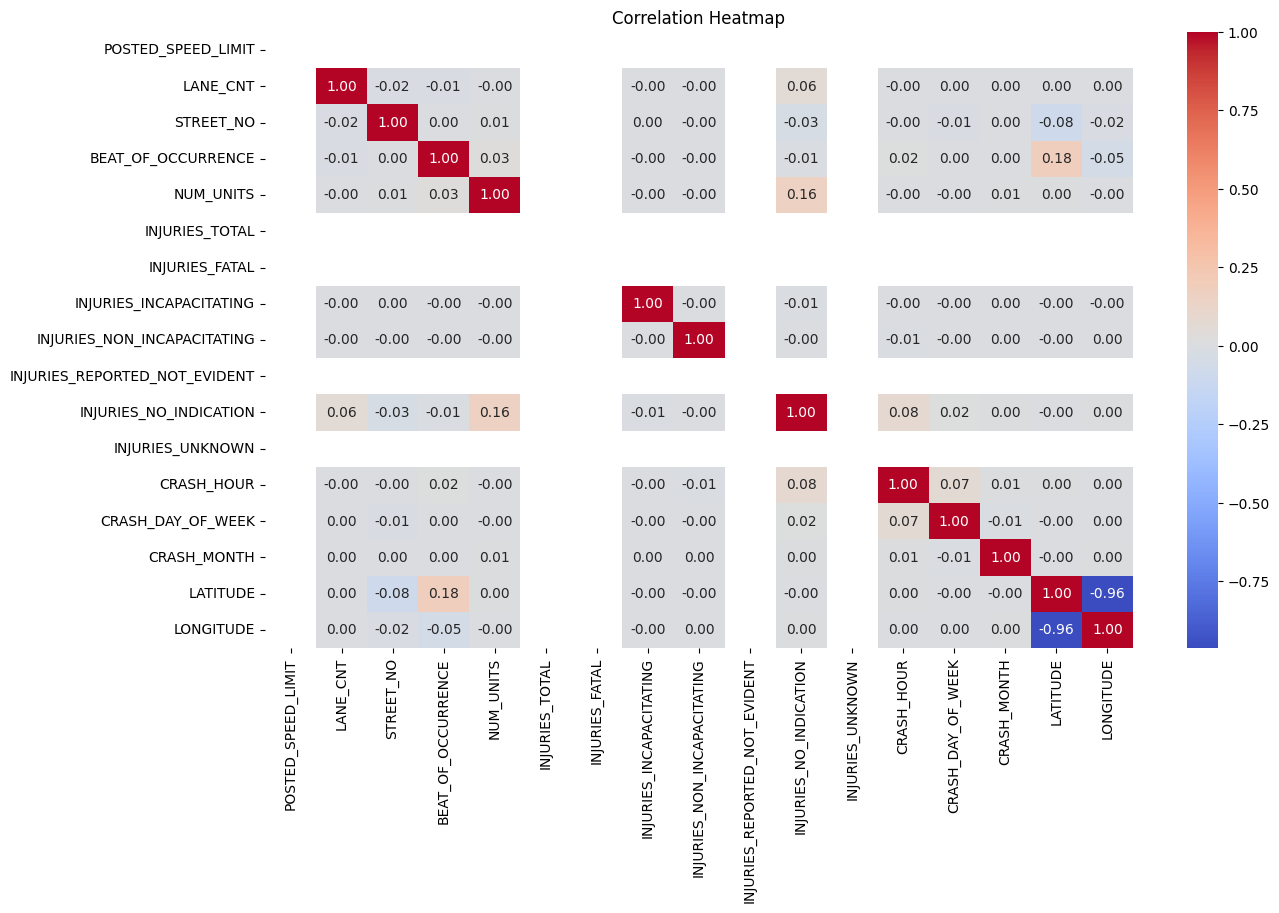

In [5]:
# Bar plot for categorical features
plt.figure(figsize=(12, 6))
df['WEATHER_CONDITION'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Weather Conditions during Crashes')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for numeric columns
plt.figure(figsize=(14, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# Step 4: Feature Engineering

We select relevant categorical features and encode them using one-hot encoding. These transformed features are merged with numeric data to prepare for modeling.

In [6]:
# Select only useful categorical features
cat_features = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFIC_CONTROL_DEVICE']
df_encoded = pd.get_dummies(df[cat_features], drop_first=True)

# Concatenate with main dataframe
df_model = pd.concat([df[numerical_cols], df_encoded], axis=1)


# Step 5(Bonus): Create Classification Target and Final Cleanup
We engineer the binary classification target variable HAS_INJURY:

* If INJURIES_TOTAL > 0 → HAS_INJURY = 1


* Otherwise → HAS_INJURY = 0

We also drop columns that could leak target information, parse the crash date, and encode all categorical variables.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 🧹 Remove target leakage columns (all detailed injury types)
leakage_cols = [
    'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_UNKNOWN', 'INJURIES_NO_INDICATION'
]

df_model = df.drop(columns=leakage_cols)

# 🎯 Create binary target column (1 if any injury, else 0)
df_model['HAS_INJURY'] = df['INJURIES_TOTAL'].apply(lambda x: 1 if x > 0 else 0)

# Drop original INJURIES_TOTAL to avoid leakage
df_model = df_model.drop(columns=['INJURIES_TOTAL'])

# 🔁 Drop any remaining irrelevant columns (example)
drop_cols = ['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'DATE_POLICE_NOTIFIED', 'LOCATION']
df_model = df_model.drop(columns=[col for col in drop_cols if col in df_model.columns])

# Convert date column
df_model['CRASH_DATE'] = pd.to_datetime(df_model['CRASH_DATE'], errors='coerce')
df_model['CRASH_YEAR'] = df_model['CRASH_DATE'].dt.year
df_model = df_model.drop(columns=['CRASH_DATE'])

# 📊 One-hot encode categorical features
df_model = pd.get_dummies(df_model, drop_first=True)

# 🚀 Define X and y
X = df_model.drop(columns=['HAS_INJURY'])
y = df_model['HAS_INJURY']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 6(Bonus): Train Random Forest Classifier
We split the dataset into training and test sets, scale the numeric features, and train a Random Forest classifier to predict injury presence. Evaluation is done via precision, recall, and F1 score.

In [12]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🎯 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


🎯 Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29632

    accuracy                           1.00     29632
   macro avg       1.00      1.00      1.00     29632
weighted avg       1.00      1.00      1.00     29632



# Step 7 (Bonus): Train Ridge Regression on Actual Injury Count

As an optional task, we train a Ridge Regression model on the actual number of injuries (INJURIES_TOTAL) to predict continuous injury counts. This is useful for estimating crash severity.

In [14]:
# If you want to model the actual injury count, uncomment and use this instead
from sklearn.metrics import mean_squared_error, r2_score

y_reg = df['INJURIES_TOTAL']
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R² Score:", r2_score(y_test, y_pred_ridge))


Ridge MSE: 0.0
R² Score: 1.0
